<a href="https://colab.research.google.com/github/HayateSato/DS_Practice/blob/main/BeansLeaf_dataload.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
from datasets import load_dataset
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00


In [ ]:
ds = load_dataset('beans')
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.95k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

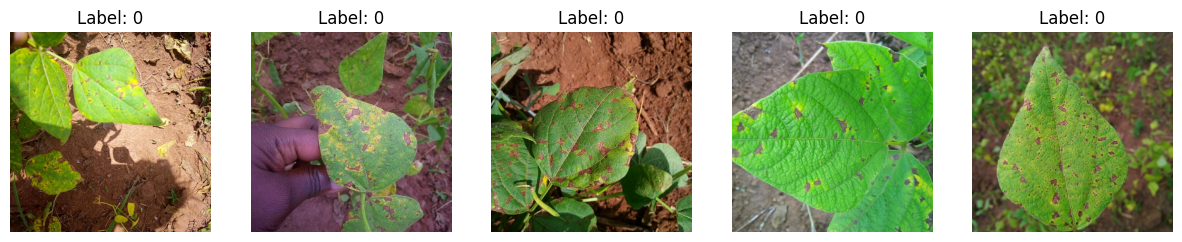

In [ ]:
import matplotlib.pyplot as plt
# Define the number of samples to display
num_samples = 5

# Plot sample images with labels
fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    sample = ds['train'][i]  # Taking samples from the training set
    image = sample['image']  # Extracting the image
    label = sample['labels']  # Extracting the label

    # Display the image
    axs[i].imshow(image)
    axs[i].set_title(f'Label: {label}')
    axs[i].axis('off')  # Hide axis

plt.show()

In [ ]:
print(ds.shape)

{'train': (1034, 3), 'validation': (133, 3), 'test': (128, 3)}


In [ ]:
import tensorflow as tf

# Parameters for image processing
IMG_SIZE = (224, 224)  # Image size for resizing
BATCH_SIZE = 32

# Preprocessing function
def preprocess(examples):
    image = examples['image']
    image = tf.image.resize(image, IMG_SIZE)  # Resize to target size
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

    label = examples['labels']
    return image, label

# Convert Hugging Face dataset into TensorFlow's tf.data.Dataset
def prepare_dataset(dataset):
    return tf.data.Dataset.from_generator(
        lambda: (preprocess(example) for example in dataset),
        output_signature=(
            tf.TensorSpec(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    ).shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Prepare train, validation, and test datasets
train_ds = prepare_dataset(ds['train'])
val_ds = prepare_dataset(ds['validation'])
test_ds = prepare_dataset(ds['test'])

# Check the dataset (optional)
for images, labels in train_ds.take(1):
    print(f'Images batch shape: {images.shape}')
    print(f'Labels batch shape: {labels.shape}')

Images batch shape: (32, 224, 224, 3)
Labels batch shape: (32,)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Parameters for image processing
IMG_SIZE = (224, 224)  # Image size for resizing
BATCH_SIZE = 32

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = Image.open(example['image']).convert('RGB')  # Assuming 'image' is a path
        label = example['labels']

        if self.transform:
            image = self.transform(image)

        return image, label

# Preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Prepare the dataset
train_dataset = CustomDataset(dataset=ds['train'], transform=preprocess)  # Replace your_huggingface_dataset
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)  # Adjust num_workers as needed

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from torch.utils.data import random_split

# Assuming train_dataset, val_dataset, and test_dataset are instances of CustomDataset
# created using the code from the previous response

# Calculate dataset sizes
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = int(0.1 * len(train_dataset))  # 10% for validation
test_size = len(train_dataset) - train_size - val_size  # Remaining 10% for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    train_dataset, [train_size, val_size, test_size]
)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Check the dataset (optional)
for images, labels in train_dataloader:
    print(f'Images batch shape: {images.shape}')
    print(f'Labels batch shape: {labels.shape}')
    break  # Check only the first batch

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py", line 420, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "<ipython-input-38-412df9c2f622>", line 21, in __getitem__
    image = Image.open(example['image']).convert('RGB')  # Assuming 'image' is a path
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3442, in open
    prefix = fp.read(16)
AttributeError: 'JpegImageFile' object has no attribute 'read'


In [ ]:
# Check for classes
class_names = ds['train'].features['labels'].names
class_names

['angular_leaf_spot', 'bean_rust', 'healthy']

In [ ]:
import tensorflow as tf
from collections import Counter

# Assuming train_ds is your TensorFlow Dataset

# Get class names from the original dataset (ds)
class_names = ds['train'].features['labels'].names  # Assuming 'labels' is the feature containing class information

# Iterate through the dataset to collect labels
class_labels = []
for _, labels in train_ds:  # Unpack images and labels from the dataset, ignore images
    class_labels.extend(labels.numpy())  # Convert labels to NumPy array and extend the list

class_counts = Counter(class_labels)

# Print class distribution
print("Class Distribution:")
# Iterate through the class_counts items, using enumerate to get the index
for class_index, (label, count) in enumerate(class_counts.items()):
    print(f"  {label}  {class_names[label]}: {count}") # Use label to index into class_names

Class Distribution:
  2  healthy: 341
  0  angular_leaf_spot: 345
  1  bean_rust: 348


Image shape: (224, 224, 3), Image dtype: float32


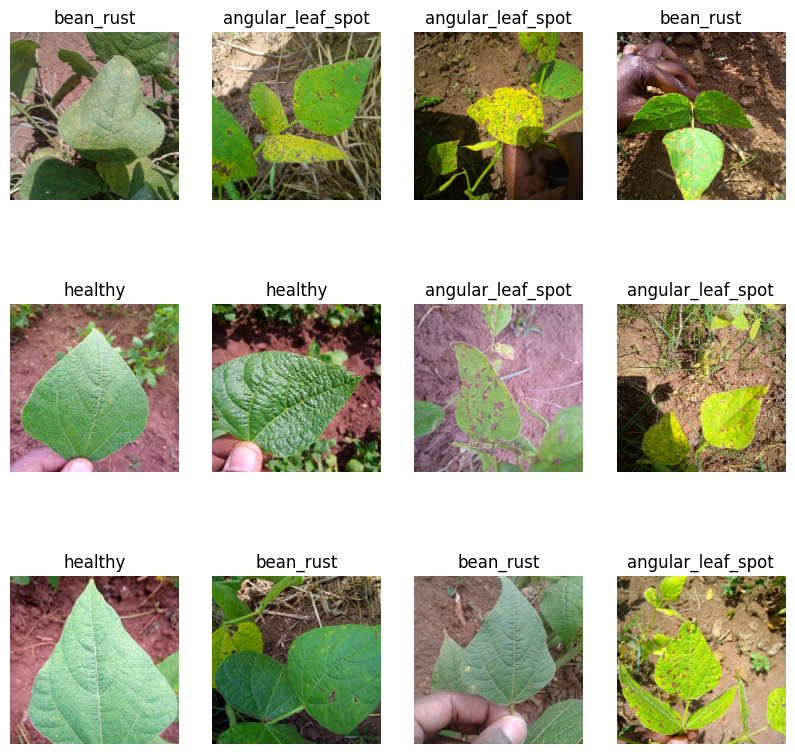

In [ ]:
import numpy as np

for images, _ in train_ds.take(1):  # Take one batch of images
    for img in images:
        img = np.array(img)  # Convert tensor to NumPy array
        print(f"Image shape: {img.shape}, Image dtype: {img.dtype}")
        break  # Checking just one image for format and size

# Unbatch the dataset to process individual images
train_ds_unbatched = train_ds.unbatch()

# Initialize the figure
plt.figure(figsize=(10, 10))

# Display 12 individual images
for i, (image, label) in enumerate(train_ds_unbatched.take(12)):  # take 12 images
    ax = plt.subplot(3, 4, i + 1)
    # Convert image to uint8 and scale to [0, 255] before displaying
    image_to_display = (image.numpy() * 255).astype("uint8")
    plt.imshow(image_to_display)  # Display image
    plt.title(class_names[label])  # Display label using class names
    plt.axis("off")  # Remove axes

plt.show()


Any Missing, Corrupted, or Duplicate Images?
====

In [ ]:
from PIL import Image

corrupted_images = []
# Iterate through the dataset, accessing individual image paths
for images, labels in train_ds:
    for img_tensor in images:
        try:
            # Convert the tensor to a NumPy array
            img_array = img_tensor.numpy()
            # Create a PIL Image from the NumPy array
            img = Image.fromarray(img_array.astype('uint8'))
            img.verify()  # Verify if the image is valid
        except (IOError, SyntaxError) as e:
            print(f"Corrupted Image: {img_tensor}")
            corrupted_images.append(img_tensor)

print(f"the number of corrupted Images: {len(corrupted_images)}")


# Iterate through the dataset, accessing individual image paths
for images, labels in train_ds:
    for img_tensor in images:
        try:
            # Convert the tensor to a NumPy array
            img_array = img_tensor.numpy()
            # Create a PIL Image from the NumPy array
            img = Image.fromarray(img_array.astype('uint8'))
            img.verify()  # Verify if the image is valid
        except (IOError, SyntaxError) as e:
            print(f"Corrupted Image: {img_tensor}")
            corrupted_images.append(img_tensor)

the number of corrupted Images: 0


In [ ]:
#duplicate images
import hashlib
import os

def file_hash(filepath):
    """Calculate the hash of a file."""
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

image_hashes = {}
duplicates = []
for img_name in os.listdir(train_path):
    img_path = os.path.join(train_path, img_name)
    # Check if the item is a file before calculating the hash
    if os.path.isfile(img_path):
        img_hash = file_hash(img_path)
        if img_hash in image_hashes:
            duplicates.append(img_name)
        else:
            image_hashes[img_hash] = img_name

print(f"the number of duplicate Images: {len(duplicates)}")

NameError: name 'train_path' is not defined

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Data Argumentation
resize_and_rescale = keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255)
])

# Image augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    # layers.RandomBrightness(factor=0.1),  # Adjust brightness by a factor (0.0 - 1.0)
    # layers.RandomContrast(factor=0.1),    # Adjust contrast by a factor (0.0 - 1.0)
    # # layers.RandomSaturation(factor=0.1),
    ######## add lighting / saturation of the image samples ##########
])

In [ ]:
# Data enhancement
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

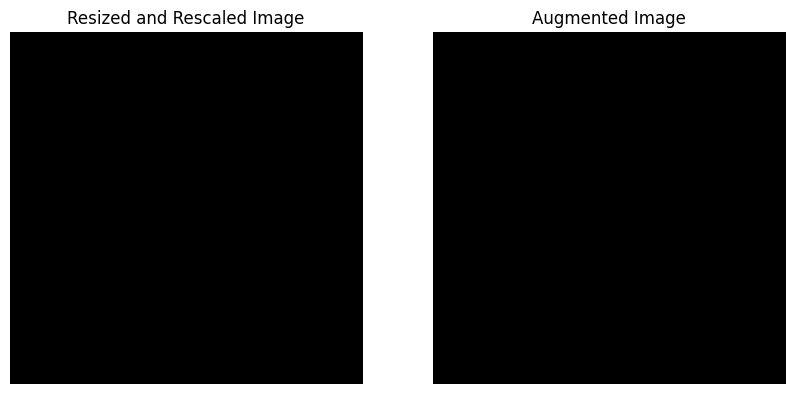

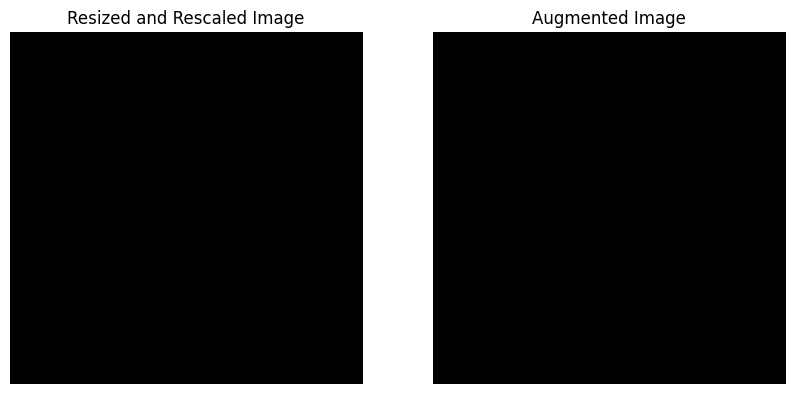

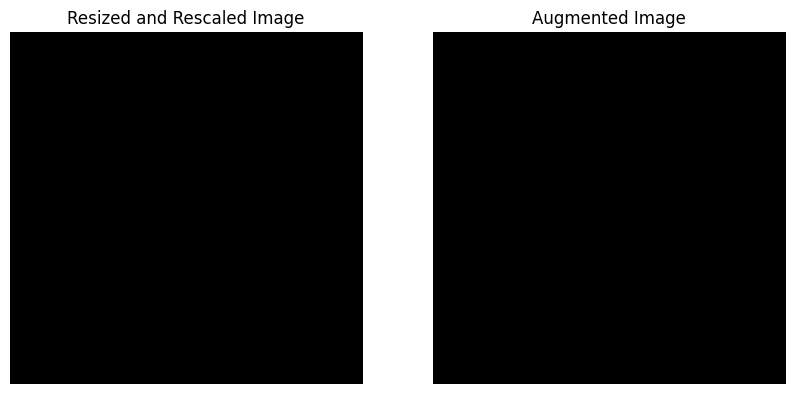

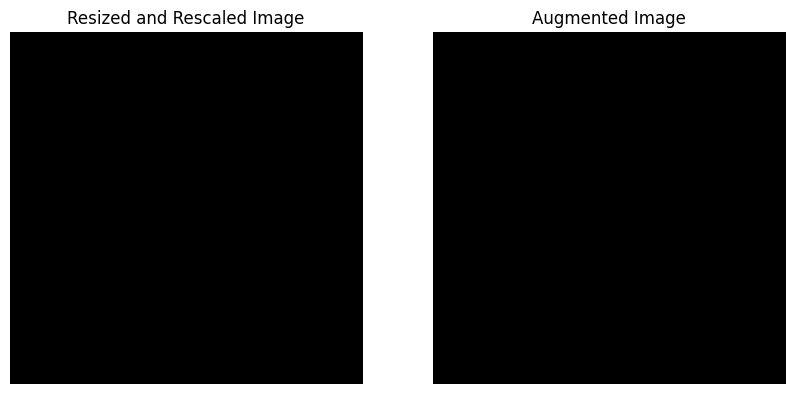

In [ ]:
# Unbatch the dataset to get individual images
unbatched_ds = train_ds.unbatch()

# Take one image and its label
for image, label in unbatched_ds.take(4):
    # Apply resizing and rescaling
    resized_image = resize_and_rescale(image)

    # Apply augmentation
    augmented_image = data_augmentation(resized_image)

    # Convert both images from float32 [0,1] to uint8 [0,255] for display
    resized_image = tf.clip_by_value(resized_image * 255, 0, 255)
    resized_image = tf.cast(resized_image, tf.uint8)

    augmented_image = tf.clip_by_value(augmented_image * 255, 0, 255)
    augmented_image = tf.cast(augmented_image, tf.uint8)

    # Plot both images side by side
    plt.figure(figsize=(10, 5))

    # Show resized image
    plt.subplot(1, 2, 1)
    plt.imshow(resized_image.numpy())
    plt.title("Resized and Rescaled Image")
    plt.axis("off")

    # Show augmented image
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image.numpy())
    plt.title("Augmented Image")
    plt.axis("off")

    plt.show()

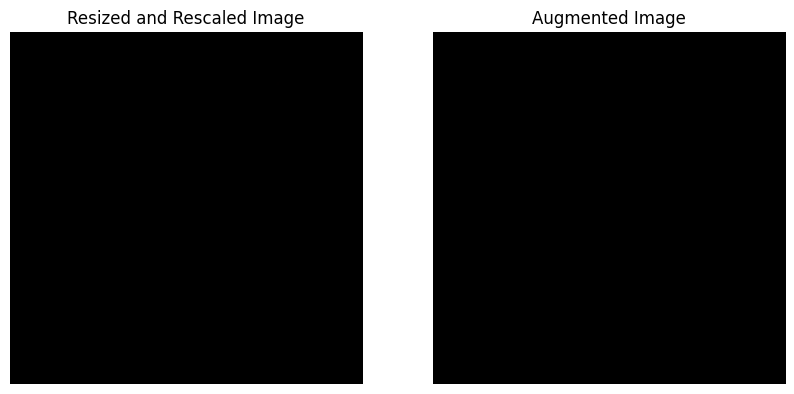

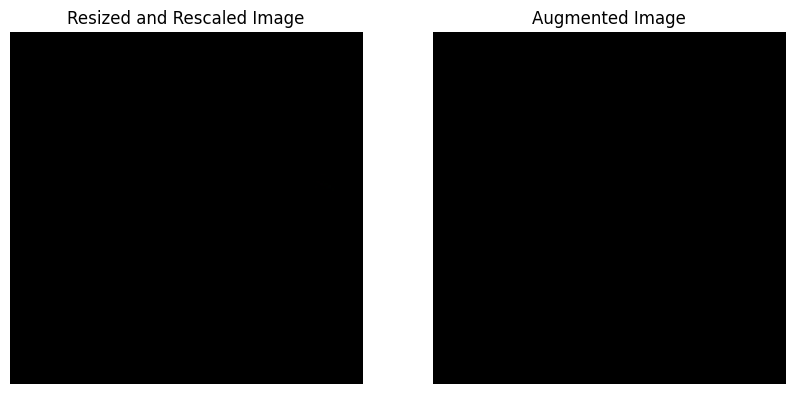

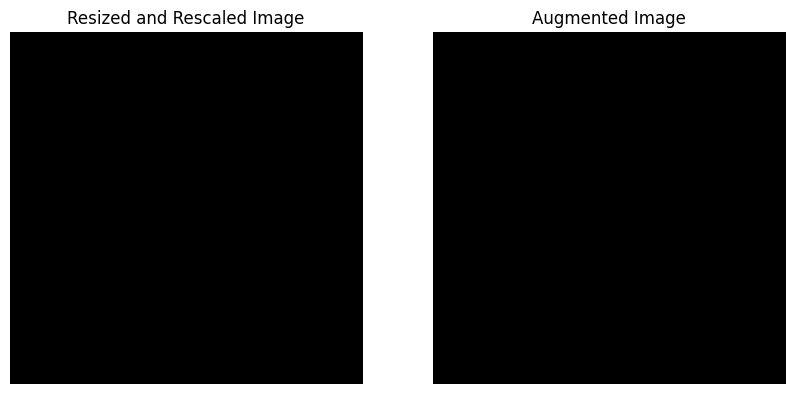

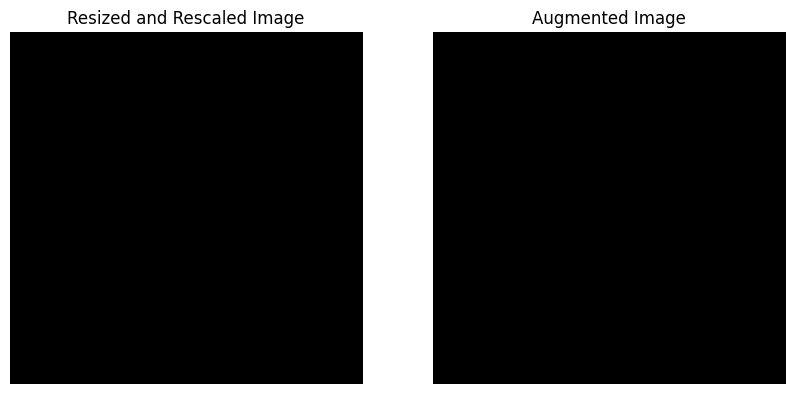

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# ... (Your resize_and_rescale and data_augmentation functions) ...

# Unbatch the dataset to get individual images
unbatched_ds = train_ds.unbatch()

# Take one image and its label
for image, label in unbatched_ds.take(4):
    # Apply resizing and rescaling
    resized_image = resize_and_rescale(image)

    # Apply augmentation
    augmented_image = data_augmentation(resized_image)

    # Convert both images from float32 [0,1] to uint8 [0,255] for display
    resized_image = tf.clip_by_value(resized_image * 255, 0, 255) # Clip values to be within 0-255
    resized_image = tf.cast(resized_image, tf.uint8) # Cast to uint8

    augmented_image = tf.clip_by_value(augmented_image * 255, 0, 255) # Clip values to be within 0-255
    augmented_image = tf.cast(augmented_image, tf.uint8) # Cast to uint8

    # Plot both images side by side
    plt.figure(figsize=(10, 5))

    # Show resized image
    plt.subplot(1, 2, 1)
    plt.imshow(resized_image.numpy())
    plt.title("Resized and Rescaled Image")
    plt.axis("off")

    # Show augmented image
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image.numpy())
    plt.title("Augmented Image") # Add title to the augmented image
    plt.axis("off")

    plt.show() # Display the plot for each image

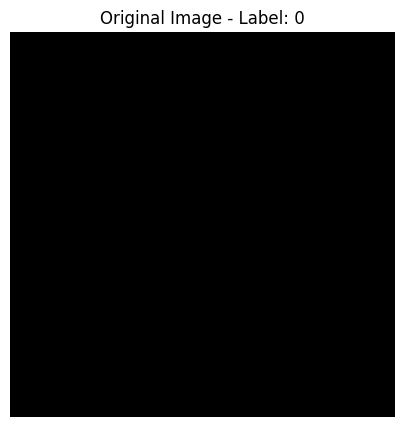

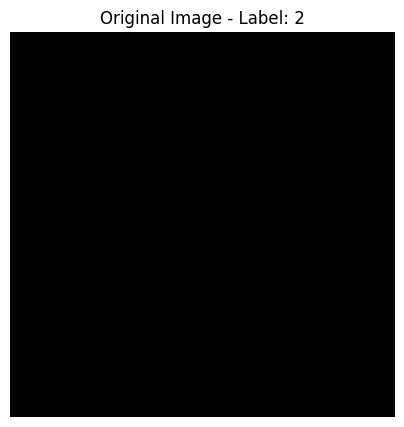

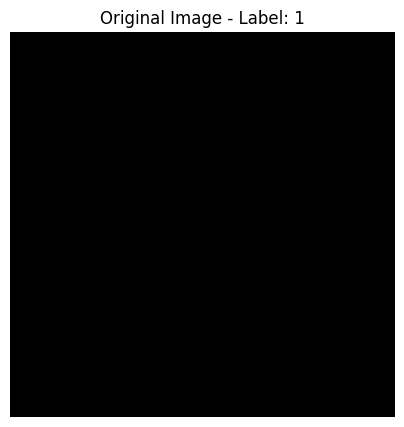

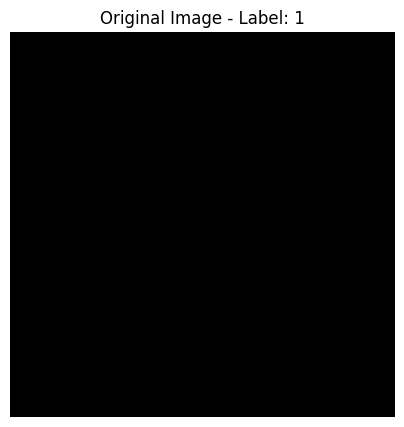

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Unbatch the dataset to get individual images
unbatched_ds = train_ds.unbatch()

# Take a few images and their labels
for image, label in unbatched_ds.take(4):
    # Display the original image directly
    plt.figure(figsize=(5, 5))
    plt.imshow(image.numpy().astype("uint8"))  # Convert to uint8 for display
    plt.title(f"Original Image - Label: {label}")
    plt.axis("off")
    plt.show()

In [ ]:
stop here

SyntaxError: invalid syntax (<ipython-input-3-a96ba3aab008>, line 1)

Business Understanding

**OBJECTIVES: You work for a start-up that provides automatic detection of plant diseases by classifying images taken of leaves. Your task is to detect whether the leaf in the image suffers from Angular Leaf Spot or Bean Rust, or is healthy. Because Vision Transformers are trending right now you decide to use an implementation based on a Vision Transformer**


**Business Understanding:**

 Image classification is a fundamental task in computer vision where the goal is to assign a label or category to an input image. It is used in many applications such as facial recognition, object detection, medical imaging, and more.

**Key Concepts in Image Classification**

Input Data: Images are typically input as pixel grids. For example, an image might be represented as a 2D array (grayscale) or a 3D array (color) where each pixel has a value.

Labels/Classes: These are the categories the model is trained to recognize. For example, in a cat vs. dog classifier, the classes would be "cat" and "dog."

Feature Extraction: The model extracts features from the images (such as edges, textures, shapes) to distinguish between different classes. Modern models use convolutional neural networks (CNNs) for automatic feature extraction.

Classification Model: The model learns to map the extracted features to a specific label. CNNs are commonly used for image classification tasks due to their strong ability to learn spatial hierarchies in the data.

Training and Testing: A dataset is typically divided into a training set (for the model to learn from) and a testing set (to evaluate the model's performance). The model learns the correlation between image features and labels during training.

Output: After processing an image, the model outputs a predicted class for that image. In some cases, it might also return a probability distribution across different classes.

**Data Gathering**:

Bean Leaf Dataset
https://www.kaggle.com/datasets/prakharrastogi534/bean-leaf-dataset?resource=download-directory&select=test

